### 0.Imports

In [1]:
!pip install load-dotenv
!pip install scikit-learn
!pip install pandas
!pip install requests
!pip install tqdm
!pip3 install ipywidgets #restart kernel after installation
!pip install matplotlib
!pip install seaborn

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a v

In [2]:
from pandas import read_csv, DataFrame, crosstab
import os
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import requests
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sn

### 1. Prepare Data & Prompts

#### 1.1 Read Data, filter columns and rename them

In [3]:
data= read_csv('cfpb_compliants.csv')
data=data[['narrative','product']]
data = data.rename(columns={'narrative': 'input', 'product' : 'output'})
data.head()


,input,output
0,currently hold one credit best buy visa paying...,credit_card
1,asked verification debt appeared credit report...,debt_collection
2,loan chase auto car accident car totaled insur...,mortgages_and_loans
3,pas due amount came denied income driven plan ...,mortgages_and_loans
4,attn collection dept submitting complaint refe...,credit_reporting


In [4]:
data.output.value_counts()

debt_collection        6642
credit_reporting       6000
mortgages_and_loans    5822
credit_card            5031
retail_banking         3863
Name: output, dtype: int64

##### Experiment: Filter to only work with 256 characters complaints

In [5]:
data_256_filter = data['input'].str.len() < 256
data_256 = data[data_256_filter]
len(data_256)

8071

In [6]:
data_256.output.value_counts()

debt_collection        2465
credit_reporting       2362
retail_banking         1187
credit_card            1066
mortgages_and_loans     991
Name: output, dtype: int64

#### 1.2 Create datasets for training and test

In [8]:
data_train, data_test, y_train, y_test = train_test_split(data_256['input'], 
                                                    data_256['output'],
                                                    test_size=0.3,
                                                    random_state=33, 
                                                    stratify=data_256['output'])
data_train = DataFrame(data_train)
data_test = DataFrame(data_test)

#### 1.3 Create training data file ( to be used thru the Tuning Studio UI )

In [9]:

data_train_and_labels = data_train.copy()
data_train_and_labels['output'] = y_train

data_train_and_labels[:2000].to_json('data/2000-compliants_classification_training_examples.json', orient ="records")


In [10]:
data_train_and_labels[:2000].output.value_counts()

credit_reporting       621
debt_collection        588
retail_banking         291
credit_card            260
mortgages_and_loans    240
Name: output, dtype: int64

#### 1.4. Create Data Test

##### Experiment: Same number of examples per class

In [11]:
data_train_sample = data_train_and_labels.groupby("output").sample(n=600, random_state=1)
data_train_sample['output'].value_counts()

credit_card            600
credit_reporting       600
debt_collection        600
mortgages_and_loans    600
retail_banking         600
Name: output, dtype: int64

In [12]:
data_train_sample.to_json('data/600c_compliants_classification_training_examples.json', orient ="records")

##### Select random 1000 examples


In [13]:
data_test_and_labels = data_test.copy()
data_test_and_labels['output'] = y_test

In [14]:
data_test_and_labels[:1000].to_json('data/testing_examples.json', orient ="records")

In [15]:
data_test_and_labels.output.value_counts()

debt_collection        740
credit_reporting       709
retail_banking         356
credit_card            320
mortgages_and_loans    297
Name: output, dtype: int64

#### Go to Tuning Studio

In [17]:
""" Classification output (verbalizer) :
classify { "credit_card", "debt_collection","mortgages_and_loans", "retail_banking","credit_reporting" } Input: {{input}} Output:
"""

#TODO : fine tuning by code

' Classification output (verbalizer) :\nclassify { "credit_card", "debt_collection","mortgages_and_loans", "retail_banking","credit_reporting" } Input: {{input}} Output:\n'

#### Prepare for Prompting

In [18]:
class Prompt:
    def __init__(self, api_key, endpoint_url):
        self.access_token = api_key
        #self.project_id = project_id
        self.endpoint_url = endpoint_url + "/generate"

    def generate(self, input, model_id, parameters):
    
        Headers = {
            "Authorization": "Bearer " + self.access_token,
            "Content-Type": "application/json",
            "Accept": "application/json"
        }
        data = {
            "model_id": model_id,
            "inputs": [input],
            "parameters": parameters
            #"project_id": self.project_id 
        }
        response = requests.post(self.endpoint_url, json=data, headers=Headers)
        if response.status_code == 200:
            return response.json()["results"][0]
        else:
            raise Exception(response.text)



In [19]:
load_dotenv()
BAM_API_URL = 'https://workbench-api.res.ibm.com/v1'
BAM_API_KEY = 'pak-s0m2moPBKZ_D-MbVbGFeSn2p1r0zqajqv17By0_SOOs'

prompt = Prompt(BAM_API_KEY, BAM_API_URL)

In [20]:
instruction_zs="""Determine the class of product expressed in the sentence.
Use either 'credit_card', 'debt_collection','mortgages_and_loans','retail_banking', or 'credit_reporting'.

sentence: {sentence}

class: 
"""

In [21]:
parameters = {
         "decoding_method": "greedy",
         "random_seed": 33,
         "repetition_penalty":1,
         "min_new_tokens": 1,
         "max_new_tokens": 10
}

In [22]:
inputs_test = [{"input": text} for text in data_test_and_labels['input']]
y_test = data_test_and_labels['output']

### 2. Test Performance FLAN-T5 ( withouth prompt tuning)

#### 2.1 ZERO SHOT PROMTING APPROACH

In [23]:

#TODO: make a bacth
model_id = "google/flan-t5-xl"
from multiprocessing.pool import ThreadPool
from time import sleep
from random import randint

max_examples=200
inputs=inputs_test[:max_examples]
y_test=y_test[:max_examples]

results_zs = []
asscoiated_test_value= []


def dosomething(test, y_test):
    sleep(5)
    results_zs.append(prompt.generate(instruction_zs.format(sentence =test['input']), model_id, parameters))
    asscoiated_test_value.append(y_test)
    print(test)


with ThreadPool(processes=5) as pool:
    pool.starmap(dosomething, zip(inputs,y_test))

{'input': 'tired bank declining credit card application reason refuse approve dont appreciate'}
{'input': 'hello im contacting cfpb help car showed credit report closed want removed credit score rand dont want closed account show account help'}
{'input': 'date amount converted purchase serviced supposedly getting wanted get money back seller doesnt want give back said doesnt dont know money want back'}
{'input': 'good evening already dispute bureau requested proof ownership far could meet requirement reason filling complaint'}
{'input': 'afni inc reported new credit account original debtor amount account believe someone else name first reported six year ago illegally showing credit report brand new delinquency result credit score dropped point disputed action often take many month respond'}
{'input': 'cancelled card charged'}
{'input': 'using app named pay rent letting link pnc bank account pay directly app'}
{'input': 'three credit bureau equifax misreported information credit report 

In [24]:
results_zs[:5]

[{'generated_text': 'credit_card',
  'generated_token_count': 4,
  'input_token_count': 77,
  'stop_reason': 'EOS_TOKEN'},
 {'generated_text': 'credit_reporting',
  'generated_token_count': 6,
  'input_token_count': 94,
  'stop_reason': 'EOS_TOKEN'},
 {'generated_text': 'credit_reporting',
  'generated_token_count': 6,
  'input_token_count': 93,
  'stop_reason': 'EOS_TOKEN'},
 {'generated_text': 'credit_reporting',
  'generated_token_count': 6,
  'input_token_count': 82,
  'stop_reason': 'EOS_TOKEN'},
 {'generated_text': 'credit_reporting',
  'generated_token_count': 6,
  'input_token_count': 116,
  'stop_reason': 'EOS_TOKEN'}]

In [25]:
y_pred_zs = [result['generated_text'] for result in results_zs]
y_pred_zs[:3]

['credit_card', 'credit_reporting', 'credit_reporting']

In [26]:
print(accuracy_score(y_pred_zs, asscoiated_test_value))

0.535


In [27]:
classes = ['credit_card', 'debt_collection','mortgages_and_loans','retail_banking', 'credit_reporting']
print(classification_report(asscoiated_test_value, y_pred_zs) )

                     precision    recall  f1-score   support

        credit_card       0.75      0.68      0.71        31
   credit_reporting       0.38      0.89      0.53        56
    debt_collection       0.86      0.11      0.19        57
mortgages_and_loans       1.00      0.33      0.50        21
     retail_banking       0.85      0.66      0.74        35

           accuracy                           0.54       200
          macro avg       0.77      0.53      0.54       200
       weighted avg       0.72      0.54      0.50       200



### 2. Test Performance Tuned FLAN-T5 

#### 3.1 Prompt Tuning Approach

In [39]:
load_dotenv()
BAM_API_URL = 'https://bam-api.res.ibm.com/v1'
BAM_API_KEY = 'pak-be4Dv1Y3vAs4rnDzd90QXIEd1I7g1kixR0VJRFrzlBg'

prompt = Prompt(BAM_API_KEY, BAM_API_URL)

In [40]:
model_id_pt ='flan-t5-xl-pt-q1KUcoko-2024-02-22-21-40-49' #learning_rate=0.3

from multiprocessing.pool import ThreadPool
from time import sleep
from random import randint


max_examples=200
inputs=inputs_test[:max_examples]
y_test=y_test[:max_examples]

results_pt = []
asscoiated_test_value= []


def dosomething(test, y_test):
    sleep(5)
    results_pt.append(prompt.generate(instruction_zs.format(sentence =test['input']), model_id_pt, parameters))
    asscoiated_test_value.append(y_test)
    print(test)


with ThreadPool(processes=5) as pool:
    pool.starmap(dosomething, zip(inputs,y_test))

{'input': 'hello im contacting cfpb help car showed credit report closed want removed credit score rand dont want closed account show account help'}
{'input': 'tired bank declining credit card application reason refuse approve dont appreciate'}
{'input': 'afni inc reported new credit account original debtor amount account believe someone else name first reported six year ago illegally showing credit report brand new delinquency result credit score dropped point disputed action often take many month respond'}
{'input': 'good evening already dispute bureau requested proof ownership far could meet requirement reason filling complaint'}
{'input': 'date amount converted purchase serviced supposedly getting wanted get money back seller doesnt want give back said doesnt dont know money want back'}
{'input': 'account federal student loan dept closed balance refinanced department education dept credit report need accurately reflect updated status'}
{'input': 'three credit bureau equifax misrepo

In [41]:
y_pred_pt = [result['generated_text'] for result in results_pt]

print(accuracy_score(y_pred_pt, asscoiated_test_value))

0.67


In [42]:
classes = ['credit_card', 'debt_collection','mortgages_and_loans','retail_banking', 'credit_reporting']
print(classification_report(asscoiated_test_value, y_pred_pt) )

                     precision    recall  f1-score   support

        credit_card       0.82      0.74      0.78        31
   credit_reporting       0.59      0.73      0.66        56
    debt_collection       0.78      0.44      0.56        57
mortgages_and_loans       0.60      0.71      0.65        21
     retail_banking       0.65      0.86      0.74        35

           accuracy                           0.67       200
          macro avg       0.69      0.70      0.68       200
       weighted avg       0.69      0.67      0.66       200



In [35]:
load_dotenv()
BAM_API_URL = 'https://workbench-api.res.ibm.com/v1'
BAM_API_KEY = 'pak-s0m2moPBKZ_D-MbVbGFeSn2p1r0zqajqv17By0_SOOs'

prompt = Prompt(BAM_API_KEY, BAM_API_URL)

In [36]:
model_id_pt ='flan-t5-xl-mpt-eNAH8YGx-2024-02-23-22-03-17' #learning_rate=0.02

from multiprocessing.pool import ThreadPool
from time import sleep
from random import randint


max_examples=200
inputs=inputs_test[:max_examples]
y_test=y_test[:max_examples]

results_pt = []
asscoiated_test_value= []


def dosomething(test, y_test):
    sleep(5)
    results_pt.append(prompt.generate(instruction_zs.format(sentence =test['input']), model_id_pt, parameters))
    asscoiated_test_value.append(y_test)
    print(test)


with ThreadPool(processes=5) as pool:
    pool.starmap(dosomething, zip(inputs,y_test))

{'input': 'tired bank declining credit card application reason refuse approve dont appreciate'}
{'input': 'date amount converted purchase serviced supposedly getting wanted get money back seller doesnt want give back said doesnt dont know money want back'}
{'input': 'afni inc reported new credit account original debtor amount account believe someone else name first reported six year ago illegally showing credit report brand new delinquency result credit score dropped point disputed action often take many month respond'}
{'input': 'hello im contacting cfpb help car showed credit report closed want removed credit score rand dont want closed account show account help'}
{'input': 'good evening already dispute bureau requested proof ownership far could meet requirement reason filling complaint'}
{'input': 'three credit bureau equifax misreported information credit report removed immediately submitted dispute document driver license social security card three bureau information deleted remov

In [37]:
y_pred_pt = [result['generated_text'] for result in results_pt]

print(accuracy_score(y_pred_pt, asscoiated_test_value))

0.765


In [38]:
classes = ['credit_card', 'debt_collection','mortgages_and_loans','retail_banking', 'credit_reporting']
print(classification_report(asscoiated_test_value, y_pred_pt) )

                     precision    recall  f1-score   support

        credit_card       0.81      0.71      0.76        31
   credit_reporting       0.67      0.79      0.72        56
    debt_collection       0.92      0.61      0.74        57
mortgages_and_loans       0.72      0.86      0.78        21
     retail_banking       0.77      0.97      0.86        35

           accuracy                           0.77       200
          macro avg       0.78      0.79      0.77       200
       weighted avg       0.79      0.77      0.76       200



### 4. Compare results after Prompt Tuning

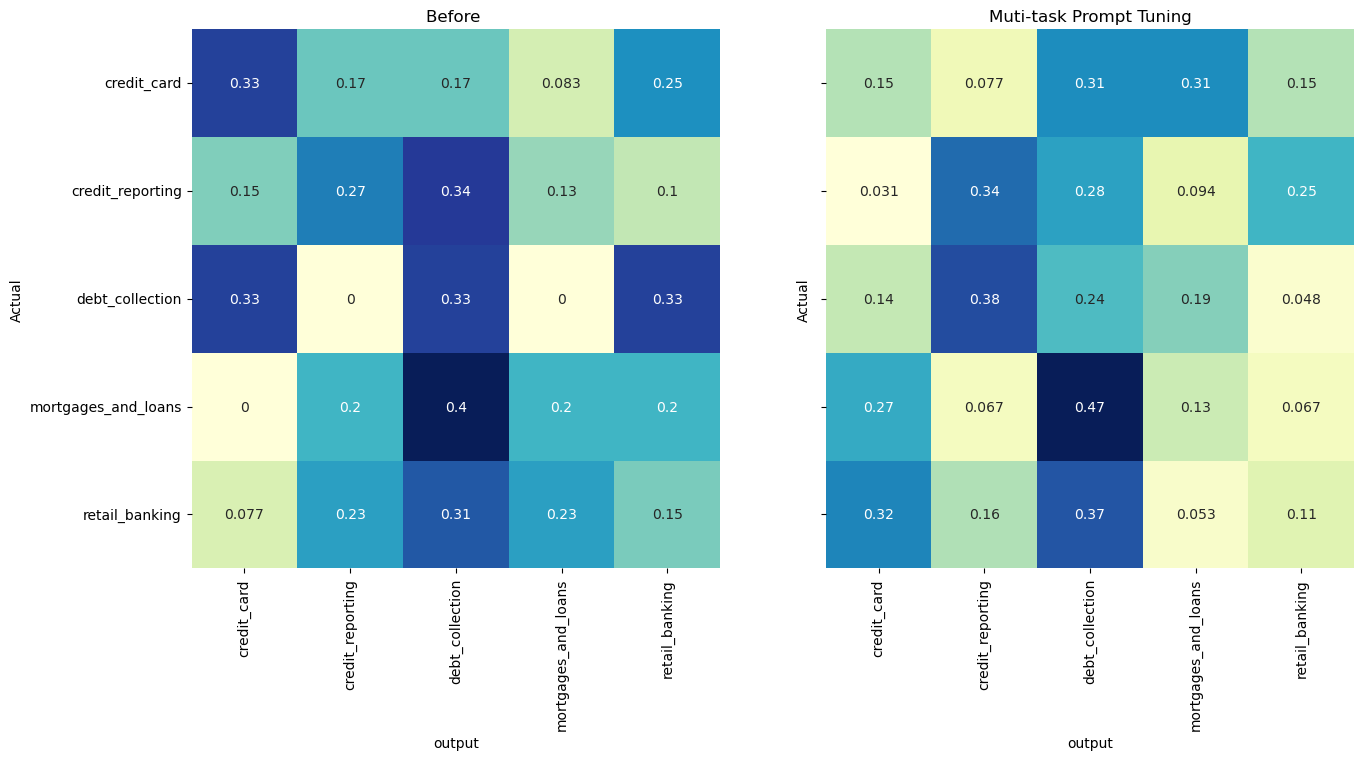

In [50]:
#TO BE DONE- EXAMPLE CODE


zero_shot_confusion_df = crosstab(y_pred_zs, y_test[:max_examples], rownames=['Actual'], normalize='index')
prompt_tuning_confusion_df = crosstab(y_pred_pt, y_test[:max_examples], rownames=['Actual'], normalize='index')

figure, (ax1, ax2) = plt.subplots(ncols=2,figsize=(15,7))

sn.heatmap(zero_shot_confusion_df, annot=True, cmap="YlGnBu", ax=ax1, cbar=False)
sn.heatmap(prompt_tuning_confusion_df, annot=True, cmap="YlGnBu", ax=ax2, cbar=False)
ax1.title.set_text("Before ")
ax2.title.set_text("Muti-task Prompt Tuning")
ax2.set_yticklabels([])

plt.show()



#sn.heatmap(few_shot_confusion_df, annot=True, cmap="YlGnBu", ax=ax3, cbar=False)
#ax2.title.set_text("Few Shot")
plt.show()


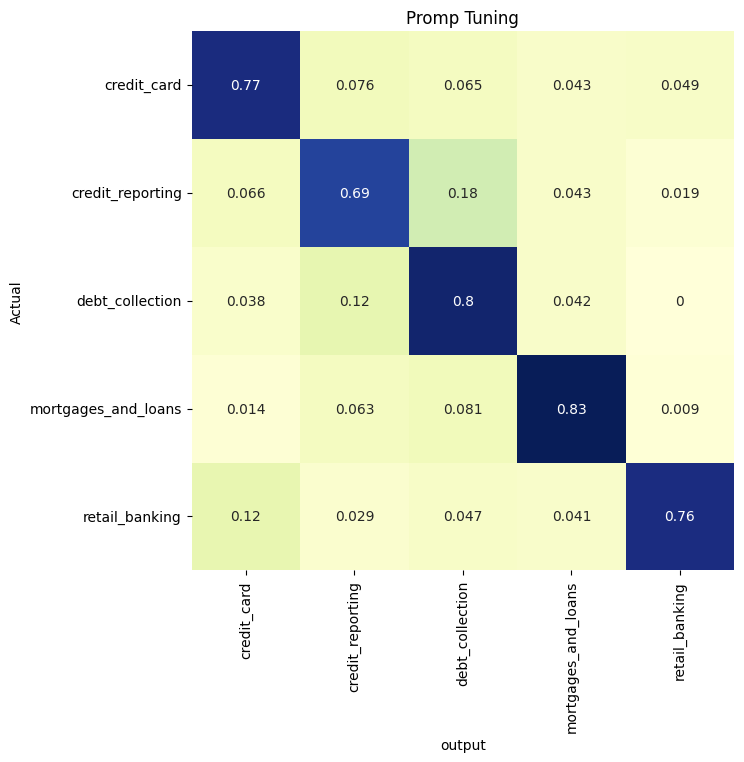

In [ ]:
prompt_tuning_confusion_df = crosstab(y_pred_pt, y_test[:max_examples], rownames=['Actual'], normalize='index')

figure4, ax4 = plt.subplots(figsize=(7,7))
sn.heatmap(prompt_tuning_confusion_df, annot=True, cmap="YlGnBu", ax=ax4, cbar=False)
ax4.title.set_text("Promp Tuning")
plt.show()

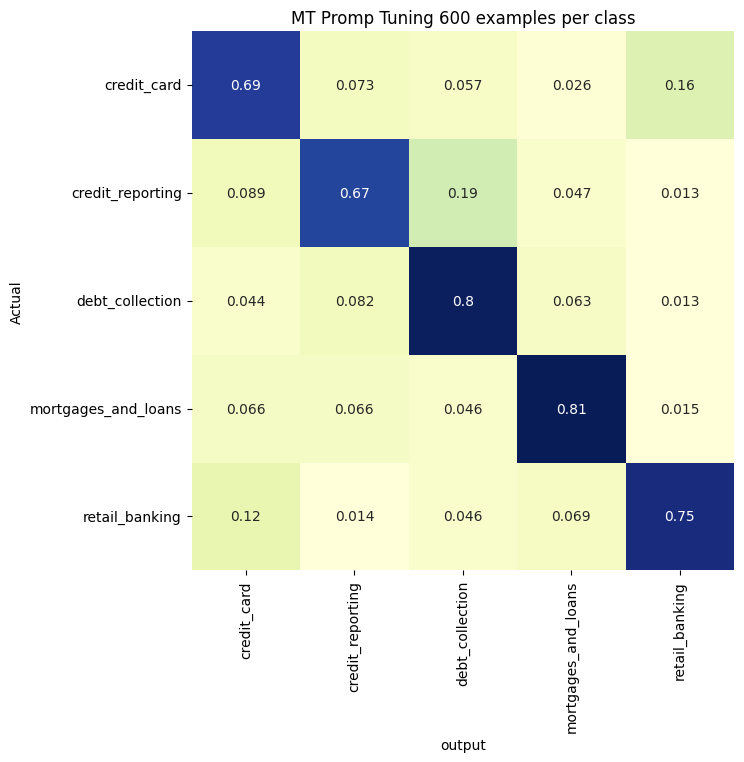

In [57]:
mt_promp_tuning_600c_confusion_df = crosstab(y_pred_mpt_600c, y_test[:max_examples], rownames=['Actual'], normalize='index')

figure5, ax5 = plt.subplots(figsize=(7,7))
sn.heatmap(mt_promp_tuning_600c_confusion_df, annot=True, cmap="YlGnBu", ax=ax5, cbar=False)
ax5.title.set_text("MT Promp Tuning 600 examples per class")
plt.show()